In [124]:
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, fetch_covtype, load_digits, make_blobs
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA as skPCA

In [4]:
def mosthighlycorrelated(mydataframe, numtoreport):
    cormatrix = mydataframe.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    print("Наилучшая корреляция:")
    print(cormatrix.head(numtoreport))
    print("Наихудшая корреляция:")
    print(cormatrix.tail(numtoreport))

In [5]:
def load_dataset(file_path):
  data = pd.read_csv(file_path, sep=',')
  data = np.array(data)
  X = data[:,1:-1]
  y = data[:,-1].astype(int)
  return (X, y)

In [6]:
class Rule(Enum):
  Kaiser = 1
  BSM = 2
  Scree = 3
  No = 4

In [7]:
def kaiser(eig_values):
    return eig_values[eig_values > eig_values.mean()].size

In [8]:
def BSM(eig_values):
  tr = eig_values.sum()
  n_eig_values = eig_values/tr
  stick = np.random.sample(eig_values.shape[0])
  stick = np.sort(stick/stick.sum())[::-1]
  return n_eig_values[n_eig_values > stick].size

In [9]:
def scree(eig_values):
  r = range(eig_values.shape[0])
  plt.plot(r, eig_values)
  plt.scatter(r, eig_values)
  plt.show()
  print("Enter number of components:")
  result = int(input())
  return result

In [10]:
map_rule_by_type = {
    Rule.BSM : BSM,
    Rule.Kaiser : kaiser,
    Rule.Scree : scree
}

In [12]:
class PCA(object):

  def __init__(self, rule = Rule.No):
    self.rule = rule

  def fit(self, X):
    mosthighlycorrelated(pd.DataFrame(X), 10)
    #covariation matrix of original components
    cov_matrix = np.cov(X.T)
    #cov_matrix visualisation
    sns.heatmap(cov_matrix, vmax=1., square=False).xaxis.tick_top()
    plt.show()
    # eigenvalues and eigenvectors calculation
    eig_val_cov, eig_vec_cov = np.linalg.eigh(cov_matrix)
    #list of pairs (value, vector)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
    #sorting pairs by decreasing eigenvalues
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    #setting number of comp-s
    self.n_components = map_rule_by_type[self.rule](-np.sort(-eig_val_cov)) if self.rule != Rule.No else X.shape[1]
    #transformation matrix
    self.mat_w = np.array([ p[1] for p in eig_pairs])[:self.n_components]
  

  def report(self):
    print('Number of components {0} {1}'.format(self.n_components, self.rule))
    print(self.mat_w)

  def transform(self, X):
    X_center = X - X.mean(axis=0)
    #transfroming data
    return np.dot(X_center, self.mat_w.T)

In [13]:
def test_pca(X ,y):
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score, roc_auc_score
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

  clf = DecisionTreeClassifier(random_state=42, max_depth=20)
  clf.fit(X_train, y_train)
  preds = clf.predict_proba(X_test)
  print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                  preds.argmax(axis=1))))

In [14]:
def apply_dataset(X,y, rule =Rule.No):
  pca_ = PCA(rule=rule)
  pca_.fit(X)
  pca_.report()
  my_pca_X = pca_.transform(X)
  test_pca(my_pca_X, y)

In [15]:
def for_all_rules(X, y):
  for rule in [Rule.No, Rule.Kaiser, Rule.BSM, Rule.Scree ]:
    apply_dataset(X, y, rule)

## BREAST CANCER - 30 variables, 2 classes

In [25]:
X, y = load_breast_cancer(return_X_y=True)
X.shape
X = StandardScaler().fit_transform(X)
X.shape


(569, 30)

(30, 30)

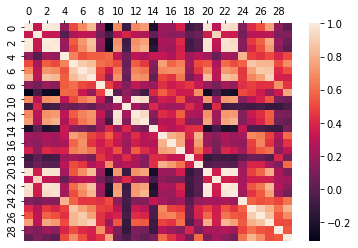

In [71]:
covmat = np.cov(X.T);
sns.heatmap(covmat, vmax=1., square=False).xaxis.tick_top()
covmat.shape

In [ ]:
bc = load_breast_cancer()
bc.feature_names

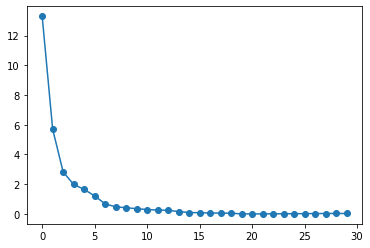

Enter number of components:


In [81]:
vals, _ = np.linalg.eig(covmat)
kKaiser = kaiser(vals)
kBSM = BSM(vals)
kScree = scree(vals)

In [82]:
[kKaiser, kBSM, kScree]

[6, 3, 3]

In [125]:
def report_by_rule(n):
    
    pca = skPCA(n_components = n)
    XPCAreduced = pca.fit_transform(X)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_matrix = pd.DataFrame(loadings, columns=['PC'+ str(i+1) for i in range(pca.n_components)], index=bc.feature_names)
    # print(loadings_matrix.to_markdown())
    array = pca.components_.T
    names = bc.feature_names
    larrray = np.sum(array, axis=1).tolist()
    larrray, names = zip(*sorted(zip(larrray, names), reverse=True))
    ranged_features = pd.DataFrame(larrray, columns=["Суммарная нагрузка"], index=names)
    # print(ranged_features.to_markdown())
    restmat = covmat - np.cov(pca.components_.T)
    rest = pd.DataFrame(restmat, columns=bc.feature_names, index=bc.feature_names)
    print(rest.to_markdown())

In [ ]:
report_by_rule(kKaiser)

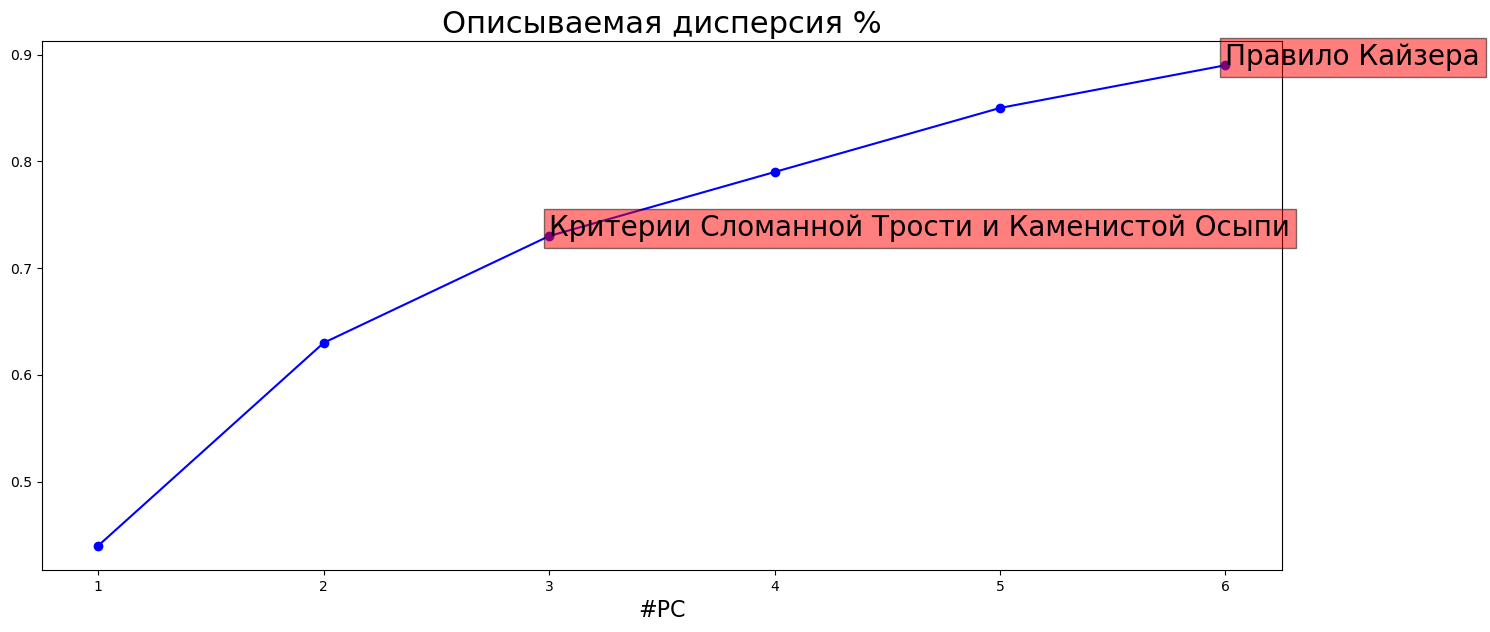

In [151]:
pca = skPCA(n_components=kKaiser)
pca.fit_transform(X)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum,'bo-')
plt.title('Описываемая дисперсия %', fontsize=22)
plt.xlabel('#PC', fontsize=16)
plt.text(kKaiser-1, variance_exp_cumsum[kKaiser-1], "Правило Кайзера",size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.text(kBSM-1, variance_exp_cumsum[kBSM-1], "Критерии Сломанной Трости и Каменистой Осыпи", size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(ticks=[i for i, _ in enumerate(variance_exp_cumsum)],labels=[i+1 for i, _ in enumerate(variance_exp_cumsum)])
plt.show()

In [148]:
[variance_exp_cumsum]

[array([0.44, 0.63, 0.73, 0.79, 0.85, 0.89])]

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              0               2     0.997855
1             20              22     0.993708
2              0               3     0.987357
3              2               3     0.986507
4             20              23     0.984015
5             22              23     0.977578
6             10              12     0.972794
7              2              22     0.970387
8              0              20     0.969539
9              2              20     0.969476
Наихудшая корреляция:
     FirstVariable  SecondVariable  Correlation
890             17              14          0.0
891             17              13          0.0
892             17              12          0.0
893             17              11          0.0
894             17              10          0.0
895             17               9          0.0
896             17               8          0.0
897             17               7          0.0
898             17

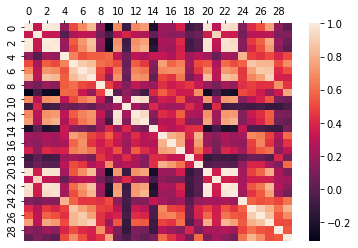

Number of components 30 Rule.No
[[-2.18902444e-01 -1.03724578e-01 -2.27537293e-01 -2.20994985e-01
  -1.42589694e-01 -2.39285354e-01 -2.58400481e-01 -2.60853758e-01
  -1.38166959e-01 -6.43633464e-02 -2.05978776e-01 -1.74280281e-02
  -2.11325916e-01 -2.02869635e-01 -1.45314521e-02 -1.70393451e-01
  -1.53589790e-01 -1.83417397e-01 -4.24984216e-02 -1.02568322e-01
  -2.27996634e-01 -1.04469325e-01 -2.36639681e-01 -2.24870533e-01
  -1.27952561e-01 -2.10095880e-01 -2.28767533e-01 -2.50885971e-01
  -1.22904556e-01 -1.31783943e-01]
 [ 2.33857132e-01  5.97060883e-02  2.15181361e-01  2.31076711e-01
  -1.86113023e-01 -1.51891610e-01 -6.01653628e-02  3.47675005e-02
  -1.90348770e-01 -3.66575471e-01  1.05552152e-01 -8.99796818e-02
   8.94572342e-02  1.52292628e-01 -2.04430453e-01 -2.32715896e-01
  -1.97207283e-01 -1.30321560e-01 -1.83848000e-01 -2.80092027e-01
   2.19866379e-01  4.54672983e-02  1.99878428e-01  2.19351858e-01
  -1.72304352e-01 -1.43593173e-01 -9.79641143e-02  8.25723507e-03
  -1.4188

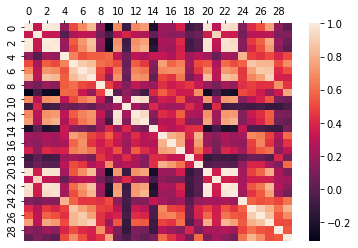

Number of components 6 Rule.Kaiser
[[-2.18902444e-01 -1.03724578e-01 -2.27537293e-01 -2.20994985e-01
  -1.42589694e-01 -2.39285354e-01 -2.58400481e-01 -2.60853758e-01
  -1.38166959e-01 -6.43633464e-02 -2.05978776e-01 -1.74280281e-02
  -2.11325916e-01 -2.02869635e-01 -1.45314521e-02 -1.70393451e-01
  -1.53589790e-01 -1.83417397e-01 -4.24984216e-02 -1.02568322e-01
  -2.27996634e-01 -1.04469325e-01 -2.36639681e-01 -2.24870533e-01
  -1.27952561e-01 -2.10095880e-01 -2.28767533e-01 -2.50885971e-01
  -1.22904556e-01 -1.31783943e-01]
 [ 2.33857132e-01  5.97060883e-02  2.15181361e-01  2.31076711e-01
  -1.86113023e-01 -1.51891610e-01 -6.01653628e-02  3.47675005e-02
  -1.90348770e-01 -3.66575471e-01  1.05552152e-01 -8.99796818e-02
   8.94572342e-02  1.52292628e-01 -2.04430453e-01 -2.32715896e-01
  -1.97207283e-01 -1.30321560e-01 -1.83848000e-01 -2.80092027e-01
   2.19866379e-01  4.54672983e-02  1.99878428e-01  2.19351858e-01
  -1.72304352e-01 -1.43593173e-01 -9.79641143e-02  8.25723507e-03
  -1.4

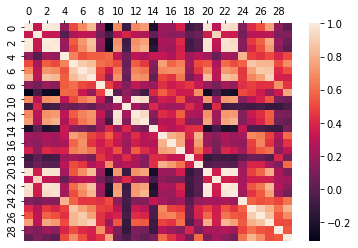

Number of components 4 Rule.BSM
[[-0.21890244 -0.10372458 -0.22753729 -0.22099499 -0.14258969 -0.23928535
  -0.25840048 -0.26085376 -0.13816696 -0.06436335 -0.20597878 -0.01742803
  -0.21132592 -0.20286964 -0.01453145 -0.17039345 -0.15358979 -0.1834174
  -0.04249842 -0.10256832 -0.22799663 -0.10446933 -0.23663968 -0.22487053
  -0.12795256 -0.21009588 -0.22876753 -0.25088597 -0.12290456 -0.13178394]
 [ 0.23385713  0.05970609  0.21518136  0.23107671 -0.18611302 -0.15189161
  -0.06016536  0.0347675  -0.19034877 -0.36657547  0.10555215 -0.08997968
   0.08945723  0.15229263 -0.20443045 -0.2327159  -0.19720728 -0.13032156
  -0.183848   -0.28009203  0.21986638  0.0454673   0.19987843  0.21935186
  -0.17230435 -0.14359317 -0.09796411  0.00825724 -0.14188335 -0.27533947]
 [ 0.00853124 -0.0645499   0.00931422 -0.02869953  0.1042919   0.07409157
  -0.00273384  0.02556354  0.04023994  0.02257409 -0.26848139 -0.37463367
  -0.26664537 -0.21600653 -0.30883898 -0.15477972 -0.17646374 -0.22465757
  -0.

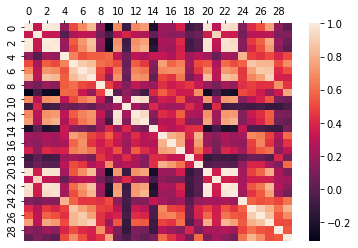

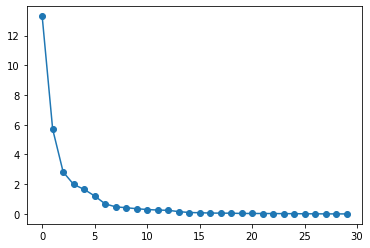

Enter number of components:
Number of components 6 Rule.Scree
[[-2.18902444e-01 -1.03724578e-01 -2.27537293e-01 -2.20994985e-01
  -1.42589694e-01 -2.39285354e-01 -2.58400481e-01 -2.60853758e-01
  -1.38166959e-01 -6.43633464e-02 -2.05978776e-01 -1.74280281e-02
  -2.11325916e-01 -2.02869635e-01 -1.45314521e-02 -1.70393451e-01
  -1.53589790e-01 -1.83417397e-01 -4.24984216e-02 -1.02568322e-01
  -2.27996634e-01 -1.04469325e-01 -2.36639681e-01 -2.24870533e-01
  -1.27952561e-01 -2.10095880e-01 -2.28767533e-01 -2.50885971e-01
  -1.22904556e-01 -1.31783943e-01]
 [ 2.33857132e-01  5.97060883e-02  2.15181361e-01  2.31076711e-01
  -1.86113023e-01 -1.51891610e-01 -6.01653628e-02  3.47675005e-02
  -1.90348770e-01 -3.66575471e-01  1.05552152e-01 -8.99796818e-02
   8.94572342e-02  1.52292628e-01 -2.04430453e-01 -2.32715896e-01
  -1.97207283e-01 -1.30321560e-01 -1.83848000e-01 -2.80092027e-01
   2.19866379e-01  4.54672983e-02  1.99878428e-01  2.19351858e-01
  -1.72304352e-01 -1.43593173e-01 -9.79641143

In [21]:
for_all_rules(X,y)

## DIGITS DATASET - 64 vars, 10 classes

In [ ]:
X, y = load_digits(return_X_y=True)
X = StandardScaler().fit_transform(X)

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46              54     0.664351
9             15              23     0.658243
Наихудшая корреляция:
      FirstVariable  SecondVariable  Correlation
3711             44               3         -0.0
3712             44               2         -0.0
3713             44               1         -0.0
3714             43              43          0.0
3715             43              42          0.0
3716             43              41          0.0
3717             43              40          0.0
3718             43              38         -0.0
3719     

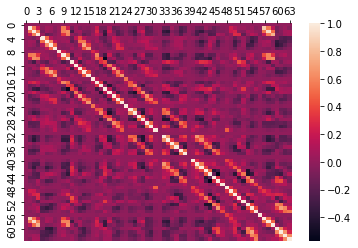

Number of components 64 Rule.No
[[ 0.00000000e+00 -1.82233917e-01 -2.85867997e-01 ... -1.03198001e-01
  -1.19810604e-01 -7.14936163e-02]
 [ 0.00000000e+00  4.70270076e-02  5.95647953e-02 ... -2.42617777e-01
  -1.65089262e-01 -7.13292370e-02]
 [ 0.00000000e+00 -2.35882143e-02  5.67987457e-02 ...  2.22795243e-02
  -1.00365586e-01 -9.24458865e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00 -6.69053630e-17 ...  9.89183859e-16
  -2.69645636e-16 -2.74640590e-16]
 [ 0.00000000e+00  0.00000000e+00 -2.11855917e-16 ...  2.68996355e-16
   7.54441952e-17 -1.51179375e-16]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Accuracy: 0.80556
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7

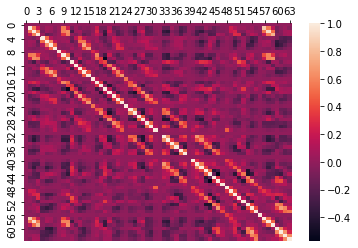

Number of components 19 Rule.Kaiser
[[ 0.         -0.18223392 -0.285868   ... -0.103198   -0.1198106
  -0.07149362]
 [ 0.          0.04702701  0.0595648  ... -0.24261778 -0.16508926
  -0.07132924]
 [ 0.         -0.02358821  0.05679875 ...  0.02227952 -0.10036559
  -0.09244589]
 ...
 [ 0.          0.17182076 -0.0181878  ...  0.03405311 -0.0283885
  -0.05504706]
 [ 0.         -0.06572235  0.01691111 ... -0.01927744 -0.04028618
  -0.0384781 ]
 [ 0.         -0.13713827 -0.02055088 ... -0.13561852 -0.07714119
   0.08593772]]
Accuracy: 0.83333
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0              2              58     0.937623
1              1              57     0.855610
2              3              59     0.767945
3             13              21     0.732505
4              6              14     0.730296
5              7              15     0.711073
6             54              61     0.707519
7             33              41     0.670915
8             46    

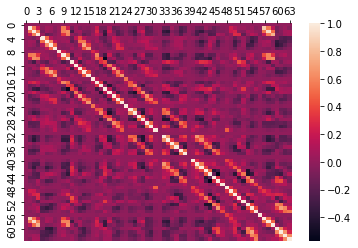

Number of components 12 Rule.BSM
[[ 0.00000000e+00 -1.82233917e-01 -2.85867997e-01 -2.20369669e-01
   2.51695591e-02  9.49725041e-03  5.24764975e-02  6.26949928e-02
  -3.47072724e-02 -2.45533684e-01 -2.29151737e-01  1.07943812e-01
  -3.62020917e-02 -3.87115946e-02  8.37807734e-02  9.27750204e-02
  -1.66993420e-02 -1.36716497e-01  6.30507547e-02  1.22879267e-01
  -1.48193479e-01  2.34842464e-02  1.71199702e-01  1.04208373e-01
   3.94881848e-03  1.16389700e-01  1.88204732e-01 -6.58604010e-02
  -1.43532569e-01  1.28207049e-01  1.80620749e-01  5.27091667e-02
   0.00000000e+00  2.38902514e-01  2.35006131e-01  5.09137360e-03
   1.31088082e-02  1.59116182e-01  1.29394163e-01  0.00000000e+00
   5.55990603e-02  1.87157069e-01  1.53533710e-01  4.68257226e-02
   1.10892715e-01  1.07209473e-01 -1.79265181e-02  2.27270999e-03
   2.88172859e-02 -4.08680044e-02 -1.10270676e-01 -3.18243987e-02
   7.90494506e-02 -6.83214736e-02 -1.21247066e-01 -4.87711942e-02
   1.83585908e-03 -1.60395688e-01 -2.798530

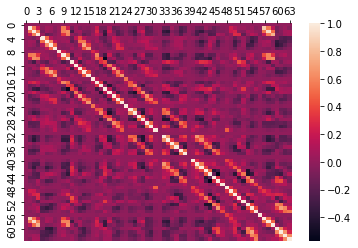

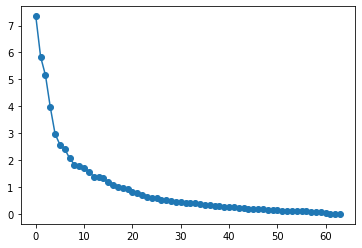

Enter number of components:
7
Number of components 7 Rule.Scree
[[ 0.00000000e+00 -1.82233917e-01 -2.85867997e-01 -2.20369669e-01
   2.51695591e-02  9.49725041e-03  5.24764975e-02  6.26949928e-02
  -3.47072724e-02 -2.45533684e-01 -2.29151737e-01  1.07943812e-01
  -3.62020917e-02 -3.87115946e-02  8.37807734e-02  9.27750204e-02
  -1.66993420e-02 -1.36716497e-01  6.30507547e-02  1.22879267e-01
  -1.48193479e-01  2.34842464e-02  1.71199702e-01  1.04208373e-01
   3.94881848e-03  1.16389700e-01  1.88204732e-01 -6.58604010e-02
  -1.43532569e-01  1.28207049e-01  1.80620749e-01  5.27091667e-02
   0.00000000e+00  2.38902514e-01  2.35006131e-01  5.09137360e-03
   1.31088082e-02  1.59116182e-01  1.29394163e-01  0.00000000e+00
   5.55990603e-02  1.87157069e-01  1.53533710e-01  4.68257226e-02
   1.10892715e-01  1.07209473e-01 -1.79265181e-02  2.27270999e-03
   2.88172859e-02 -4.08680044e-02 -1.10270676e-01 -3.18243987e-02
   7.90494506e-02 -6.83214736e-02 -1.21247066e-01 -4.87711942e-02
   1.8358590

In [ ]:
for_all_rules(X, y)

## Custom dataset - 1000 vars, 20 classes

In [ ]:
X, y = make_blobs(n_samples=500, n_features=600, centers=20, cluster_std=2)
X = StandardScaler().fit_transform(X)

Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            157             326     0.760987
1            429             499    -0.733383
2            146             275    -0.729973
3             57             365     0.721036
4            344             404    -0.719879
5            286             311     0.717435
6            398             463    -0.712833
7            193             552     0.711495
8             21             215     0.705660
9             61             172    -0.705225
Наихудшая корреляция:
        FirstVariable  SecondVariable  Correlation
359990            401             244          0.0
359991            401             246         -0.0
359992            401             253         -0.0
359993            401             247         -0.0
359994            401             248         -0.0
359995            401             249          0.0
359996            401             250         -0.0
359997            401             251     

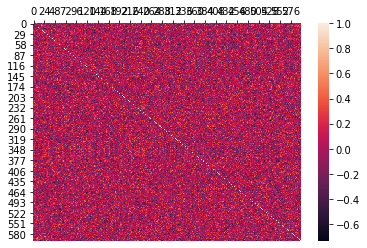

Number of components 600 Rule.No
[[ 0.01366578 -0.06535188 -0.00294321 ...  0.03728388  0.11676258
  -0.07565772]
 [-0.00799857 -0.03852106 -0.08603429 ... -0.02818114 -0.00571195
  -0.00233171]
 [ 0.04526297 -0.05803965 -0.02766472 ...  0.01939733  0.02768244
   0.03556775]
 ...
 [ 0.          0.01393494 -0.00438735 ...  0.02295386  0.07100302
   0.02403217]
 [ 0.          0.00919091  0.00797027 ...  0.02994194 -0.03182348
  -0.01326463]
 [ 0.         -0.04091708 -0.00132502 ...  0.07416511 -0.05352163
  -0.03347015]]
Accuracy: 0.98000
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            157             326     0.760987
1            429             499    -0.733383
2            146             275    -0.729973
3             57             365     0.721036
4            344             404    -0.719879
5            286             311     0.717435
6            398             463    -0.712833
7            193             552     0.711495
8             21     

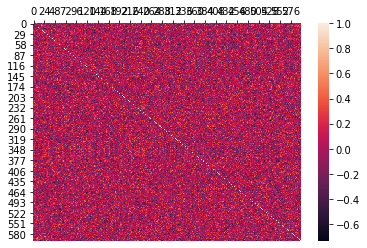

Number of components 19 Rule.Kaiser
[[ 0.01366578 -0.06535188 -0.00294321 ...  0.03728388  0.11676258
  -0.07565772]
 [-0.00799857 -0.03852106 -0.08603429 ... -0.02818114 -0.00571195
  -0.00233171]
 [ 0.04526297 -0.05803965 -0.02766472 ...  0.01939733  0.02768244
   0.03556775]
 ...
 [ 0.05941165  0.01447082  0.02512878 ...  0.00481874 -0.00996101
  -0.03936067]
 [-0.04063407 -0.02271629 -0.0449854  ...  0.03447786  0.02079947
  -0.0030234 ]
 [ 0.00687889 -0.00579895 -0.06196373 ... -0.02721475  0.04257325
  -0.03787032]]
Accuracy: 0.98667
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            157             326     0.760987
1            429             499    -0.733383
2            146             275    -0.729973
3             57             365     0.721036
4            344             404    -0.719879
5            286             311     0.717435
6            398             463    -0.712833
7            193             552     0.711495
8             21  

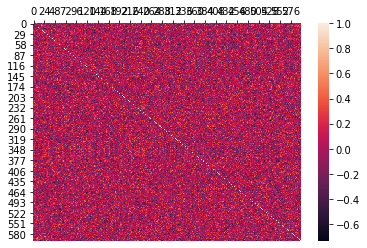

Number of components 19 Rule.BSM
[[ 0.01366578 -0.06535188 -0.00294321 ...  0.03728388  0.11676258
  -0.07565772]
 [-0.00799857 -0.03852106 -0.08603429 ... -0.02818114 -0.00571195
  -0.00233171]
 [ 0.04526297 -0.05803965 -0.02766472 ...  0.01939733  0.02768244
   0.03556775]
 ...
 [ 0.05941165  0.01447082  0.02512878 ...  0.00481874 -0.00996101
  -0.03936067]
 [-0.04063407 -0.02271629 -0.0449854  ...  0.03447786  0.02079947
  -0.0030234 ]
 [ 0.00687889 -0.00579895 -0.06196373 ... -0.02721475  0.04257325
  -0.03787032]]
Accuracy: 0.98667
Наилучшая корреляция:
   FirstVariable  SecondVariable  Correlation
0            157             326     0.760987
1            429             499    -0.733383
2            146             275    -0.729973
3             57             365     0.721036
4            344             404    -0.719879
5            286             311     0.717435
6            398             463    -0.712833
7            193             552     0.711495
8             21     

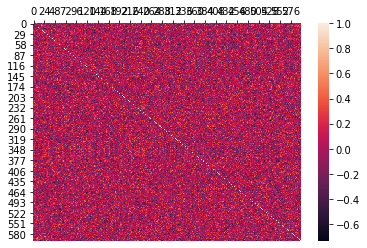

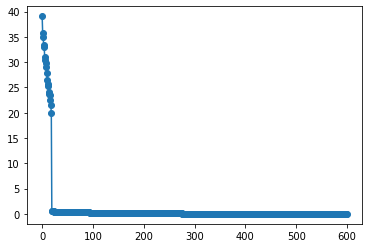

Enter number of components:
8
Number of components 8 Rule.Scree
[[ 0.01366578 -0.06535188 -0.00294321 ...  0.03728388  0.11676258
  -0.07565772]
 [-0.00799857 -0.03852106 -0.08603429 ... -0.02818114 -0.00571195
  -0.00233171]
 [ 0.04526297 -0.05803965 -0.02766472 ...  0.01939733  0.02768244
   0.03556775]
 ...
 [-0.04983106  0.02288093 -0.03979632 ...  0.01361808 -0.02929934
  -0.01978348]
 [ 0.04254277 -0.0079182   0.05072786 ... -0.01039008  0.02034233
  -0.00618736]
 [ 0.03088721 -0.00373885  0.00968075 ...  0.05068026  0.01680388
   0.06151663]]
Accuracy: 0.98667


In [ ]:
for_all_rules(X, y)